In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro

import matplotlib.pyplot as plt
import seaborn as sns

from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = n_feature0 - 1

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                mu_baseline = numpyro.sample(
                    "mu_baseline",
                    dist.TruncatedNormal(5, 10, low=0)
                )
                sigma_baseline = numpyro.sample(
                    "sigma_baseline",
                    dist.HalfNormal(10.0)
                )

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    baseline = numpyro.sample(
                        "baseline",
                        dist.TruncatedNormal(mu_baseline, sigma_baseline, low=0)
                    )

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_delta = numpyro.sample("mu_delta", dist.Normal(0, 10))
                sigma_delta = numpyro.sample("sigma_delta", dist.HalfNormal(10.0))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    delta = numpyro.sample("delta", dist.Normal(mu_delta, sigma_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(10))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(2))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(10))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([baseline, baseline + delta], axis=1)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [3]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/human/intraoperative/config.toml")

config = Config(toml_path=toml_path)

model = HierarchicalBayesianModel(config=config)


2023-09-26 12:06:02,476 - hbmep.config - INFO - Verifying configuration ...
2023-09-26 12:06:02,476 - hbmep.config - INFO - Success!
2023-09-26 12:06:02,490 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link


In [4]:
src = "/home/vishu/data/hbmep-processed/human/intraoperative/data.csv"
df = pd.read_csv(src)

subset = [
    'scapptio001'
]
ind = ~df[model.subject].isin(subset)
df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)

2023-09-26 12:06:02,549 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/intraoperative
2023-09-26 12:06:02,549 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/intraoperative
2023-09-26 12:06:02,550 - hbmep.dataset.core - INFO - Processing data ...
2023-09-26 12:06:02,551 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-09-26 12:06:02,586 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-09-26 12:08:01,162 - hbmep.utils.utils - INFO - func:run_inference took: 1 min and 58.58 sec


In [6]:
mcmc.print_summary(prob=.95)


                         mean       std    median      2.5%     97.5%     n_eff     r_hat
           H[0,0,0]      7.11      5.23      5.86      0.66     17.29   2583.81      1.00
           H[0,1,0]      9.27      7.55      7.12      0.90     24.25   2077.81      1.00
           H[1,0,0]      1.49      0.07      1.48      1.35      1.64   1094.50      1.01
           H[1,1,0]      8.78      7.83      6.54      0.31     23.57   2253.75      1.00
           H[2,0,0]      5.59      5.24      4.35      0.02     15.64   1434.27      1.00
           H[2,1,0]      8.48      7.52      6.42      0.17     22.96   2487.99      1.00
           H[3,0,0]      2.03      3.62      0.53      0.39     10.36     71.82      1.04
           H[3,1,0]      8.56      7.73      6.41      0.21     23.63   2247.55      1.00
           H[4,0,0]      5.98      4.14      3.88      2.96     14.59    993.73      1.00
           H[4,1,0]      6.97      7.69      4.31      0.19     22.57   1614.82      1.00
         

In [7]:
prediction_df = model.make_prediction_dataset(df=df)
prediction_df.shape

2023-09-26 12:08:01,454 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


(2400, 3)

In [8]:
posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

2023-09-26 12:08:05,484 - hbmep.utils.utils - INFO - func:predict took: 3.95 sec


In [9]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-09-26 12:08:05,527 - hbmep.model.baseline - INFO - Rendering ...
2023-09-26 12:08:09,900 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/recruitment_curves.pdf
2023-09-26 12:08:09,900 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 4.39 sec


In [10]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-09-26 12:08:09,956 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...


2023-09-26 12:08:14,951 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/intraoperative/posterior_predictive_check.pdf
2023-09-26 12:08:14,952 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 5.02 sec
2023-09-26 12:08:14,952 - hbmep.utils.utils - INFO - func:render_predictive_check took: 5.02 sec


In [11]:
mu_delta = posterior_samples["mu_delta"]
mu_delta.shape


(4000, 1, 1)

In [12]:
encoder_dict[model.features[0]].inverse_transform(np.array([0, 1]))

array(['L', 'M'], dtype=object)

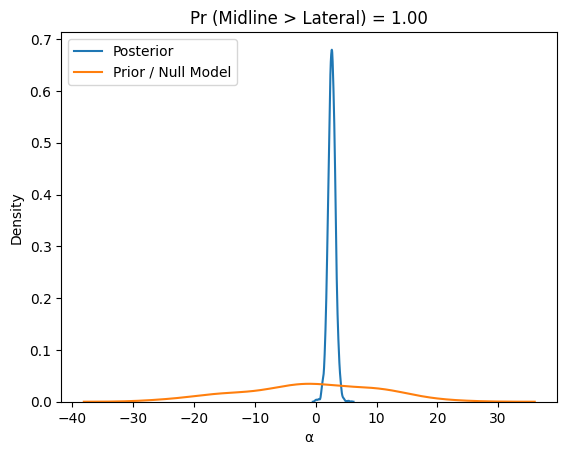

In [13]:
posterior = mu_delta.reshape(-1,)
prior = dist.Normal(0, 10).sample(model.rng_key, sample_shape=(100,))

sns.kdeplot(posterior, label="Posterior")
sns.kdeplot(prior, label="Prior / Null Model")

plt.title(f"Pr (Midline > Lateral) = {(posterior > 0).mean():.2f}")
plt.xlabel("α")
plt.legend(loc="upper left")

In [14]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)

In [15]:
# import pickle

# with open(dest, "rb") as g:
#     model_, mcmc_, posterior_samples_ = pickle.load(g)
